# C19 Food insecurity

AKA Looking at FAO's food insecurity calculations with the imports and exports turned off

We're using the FAO's food balance sheets for all the countries in the world.  These go up to 2018 - that's recent enough for a rough calculation. Usually we average over 3 years to get a smoothed annual score, so will do that too. 

First, we have to work out which number we need, and how the FAO got it from the other numbers in this table

Reading the sleeve notes in the webpage for this dataset ('definitions and standards' on http://www.fao.org/faostat/en/#data/FBS), we see that the number we want for each country is Item Code = 2901 (Grand Total), Element Code = 664 (Food supply in kcal per capita per day).   Let's dig into how this got created. 

In [1]:
import pandas as pd

df = pd.read_csv('../DATA/FoodBalanceSheets_E_All_Data/FoodBalanceSheets_E_All_Data.csv',
                 encoding='iso-8859-1')
df.head()

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y2014,Y2014F,Y2015,Y2015F,Y2016,Y2016F,Y2017,Y2017F
0,2,Afghanistan,2501,Population,511,Total Population - Both sexes,1000 persons,33370.79,S,34413.60,S,35383.03,S,36296.11,S
1,2,Afghanistan,2501,Population,5301,Domestic supply quantity,1000 tonnes,0.00,S,0.00,S,0.00,S,0.00,S
2,2,Afghanistan,2901,Grand Total,664,Food supply (kcal/capita/day),kcal/capita/day,2019.00,Fc,1978.00,Fc,2001.00,Fc,2000.00,Fc
3,2,Afghanistan,2901,Grand Total,674,Protein supply quantity (g/capita/day),g/capita/day,56.11,Fc,54.62,Fc,54.56,Fc,54.09,Fc
4,2,Afghanistan,2901,Grand Total,684,Fat supply quantity (g/capita/day),g/capita/day,32.77,Fc,30.41,Fc,31.24,Fc,30.62,Fc


So we did some bottom-up reading in the 'Element' part of the 'definitions and standards', which we'll ignore at this point (TL;DR how Element Code 5301, Domestic Supply Quantity, was created). 

For this part of the code, we need to know how the Grand Total was created.  Also in the 'definitions and standards' is an 'Item Group' list. The list of items isn't flat - it has structure - and this tells us that structure.  We're going to grab everything immediately below the 'Grand Total' code (2901) in the structure, and throw it into a dataframe called dfc, and an array called cats. 

In [2]:
dfcats = pd.read_csv('../DATA/FAOSTAT_data_3-24-2020_itemtotals.csv')
dfc = dfcats[dfcats['Item Group Code']==2901][['Item Code', 'Item', 'Factor']]
cats = dfc['Item Code'].to_list()
dfc

,Item Code,Item,Factor
64,2659,"Alcohol, Non-Food",1
65,2617,Apples and products,1
66,2769,"Aquatic Animals, Others",1
67,2775,Aquatic Plants,1
68,2615,Bananas,1
69,2513,Barley and products,1
70,2546,Beans,1
71,2656,Beer,1
72,2658,"Beverages, Alcoholic",1
73,2657,"Beverages, Fermented",1


Let's double check that. If we're right, the values in the row for Item Code = 2901 should be the same as the sum of the values in the 'cats' rows

Eh.  Not exact, but close enough.  So when we play this backwards, we can sum the cats rows to get the grand total for each country. 

In [3]:
#dfx = df[df['Area']=='Afghanistan'].copy()
dfx = df[df['Area']=='United States of America'].copy()
yrs = ['Y2014', 'Y2015', 'Y2016', 'Y2017']
print('{}'.format(dfx[(dfx['Element Code']==664)&(dfx['Item Code']==2901)][yrs]))
dfx[(dfx['Element Code']==664)&(dfx['Item Code'].isin(cats))][yrs].sum()

         Y2014   Y2015   Y2016   Y2017
240075  3709.0  3731.0  3747.0  3766.0


Y2014    3705.0
Y2015    3732.0
Y2016    3747.0
Y2017    3762.0
dtype: float64

We want to see what countries look like without imports.  The place to do that is in the DSQ (Domestic Supply Quantity) calculations, which look like: 

DSQ = P + I - E + CIS
* DSQ = Domestic supply quantity, element code 5301
* P = Production, element code 5511
* I = Imports, element code 5611
* E = exports, element code 5911
* CIS = change in stocks, element code 5072

I've hand-checked this against several countries and products, and this equation is sound for all of them.

So now we're at Element Code 664 (Food Supply) for bananas. How do we relate that to Element code 5301 (Domestic Supply quantity) for bananas? 

Page 21 of document x9892e00.pdf (FAO's "Food Balance Sheets: a handbook") gives us the equations for calculating kcal/c/day
* Food (5142) is calculated from DSQ. Not sure how yet, but it looks from  x9892e00.pdf as though there might be a separate equation for each food type
* Food supply (664) = (Food / population / 365) * food_composition
* food_composition is listed in items in a hard-to-get-without-string-search form - but we can calculate it from the original {Food supply, Food, population} figures. 

Reading thrilling things like
* http://www.fao.org/fileadmin/templates/ess/documents/methodology/fbs3-edg.pdf
* https://github.com/SWS-Methodology/faoswsFood
* definitions and standards in http://www.fao.org/faostat/en/#data/FBS


# Try a really nasty approximation

Let's see what happens if we nix the import and export, and use that as a percentage change in the calories available for each food quantity
* If DSQ = P + I - E + CIS
* Try newDSQ = P + CIS
* Try food supply (664) * newDSQ/DSQ for each product
* Try summing the food supplies for each country
* Look at the differences. Plot them? 

In [4]:
#yrs = ['Y2014', 'Y2015', 'Y2016', 'Y2017']
yrs = ['Y2017']
inds = ['Area', 'Area Code', 'Item Code', 'Item']

def mkdfel(df, el): 
    dfel = (df[(df['Element Code']==el)&(df['Item Code'].isin(cats))][inds+yrs]).copy()
    newcols = {col:'{}_{}'.format(col,el) for col in set(dfel.columns)-set(inds)}
    dfel.rename(columns=newcols, inplace=True)
    return dfel

elements = {}
for el in [664, 5511, 5611, 5911, 5072, 5301]: 
    elements[el] = mkdfel(df, el)
elements[5301]

,Area,Area Code,Item Code,Item,Y2017_5301
32,Afghanistan,2,2511,Wheat and products,6701.0
49,Afghanistan,2,2805,Rice (Milled Equivalent),753.0
66,Afghanistan,2,2513,Barley and products,110.0
83,Afghanistan,2,2514,Maize and products,208.0
100,Afghanistan,2,2515,Rye and products,0.0
115,Afghanistan,2,2516,Oats,0.0
129,Afghanistan,2,2517,Millet and products,10.0
146,Afghanistan,2,2518,Sorghum and products,0.0
160,Afghanistan,2,2520,"Cereals, Other",0.0
194,Afghanistan,2,2532,Cassava and products,NaN


In [5]:
dfi = pd.merge(elements[664], elements[5511], on=inds)
dfi = pd.merge(dfi, elements[5611], on=inds)
dfi = pd.merge(dfi, elements[5911], on=inds)
dfi = pd.merge(dfi, elements[5072], on=inds)
dfi = pd.merge(dfi, elements[5301], on=inds)
dfi.fillna(0, inplace=True)
dfi

,Area,Area Code,Item Code,Item,Y2017_664,Y2017_5511,Y2017_5611,Y2017_5911,Y2017_5072,Y2017_5301
0,Afghanistan,2,2511,Wheat and products,1331.0,4281.0,2302.0,0.0,-119.0,6701.0
1,Afghanistan,2,2805,Rice (Milled Equivalent),135.0,338.0,415.0,0.0,0.0,753.0
2,Afghanistan,2,2513,Barley and products,5.0,95.0,15.0,0.0,0.0,110.0
3,Afghanistan,2,2514,Maize and products,11.0,174.0,13.0,0.0,-21.0,208.0
4,Afghanistan,2,2517,Millet and products,2.0,9.0,0.0,0.0,-1.0,10.0
5,Afghanistan,2,2520,"Cereals, Other",0.0,0.0,0.0,0.0,0.0,0.0
6,Afghanistan,2,2531,Potatoes and products,13.0,513.0,230.0,5.0,414.0,324.0
7,Afghanistan,2,2542,Sugar (Raw Equivalent),88.0,2.0,483.0,0.0,155.0,331.0
8,Afghanistan,2,2543,"Sweeteners, Other",1.0,0.0,17.0,0.0,0.0,17.0
9,Afghanistan,2,2745,Honey,0.0,1.0,0.0,0.0,0.0,2.0


DSQ = P + I - E + CIS

* DSQ = Domestic supply quantity, element code 5301
* P = Production, element code 5511
* I = Imports, element code 5611
* E = exports, element code 5911
* CIS = change in stocks, element code 5072

In [6]:
dfi['DSQold'] = dfi['Y2017_5511'] + dfi['Y2017_5611'] - dfi['Y2017_5911'] + dfi['Y2017_5072']
dfi['DSQdiff'] = dfi['Y2017_5301'] - dfi['DSQold']
dfi['DSQnew'] = dfi['Y2017_5511'] + dfi['Y2017_5072']
dfi['DSQratio'] = dfi['DSQnew'] / dfi['DSQold']
dfi['664new'] = dfi['Y2017_664'] * dfi['DSQratio']
dfi.fillna(0, inplace=True)
dfi[inds +['Y2017_5301', 'DSQold', 'DSQdiff', 'DSQnew', 'DSQratio', 'Y2017_664', '664new']].sort_values('DSQdiff', ascending=False)

,Area,Area Code,Item Code,Item,Y2017_5301,DSQold,DSQdiff,DSQnew,DSQratio,Y2017_664,664new
9223,World,5000,2562,Palm kernels,326383.0,301067.0,25316.0,301067.0,1.000000,0.0,0.000000
9811,Americas,5200,2511,Wheat and products,80202.0,57434.0,22768.0,95819.0,1.668332,466.0,777.442874
9906,Northern America,5203,2511,Wheat and products,42269.0,21859.0,20410.0,67253.0,3.076673,615.0,1892.154033
10446,Eastern Asia,5302,2536,Sugar cane,115690.0,96912.0,18778.0,96814.0,0.998989,0.0,0.000000
1706,China,351,2536,Sugar cane,114392.0,95615.0,18777.0,95517.0,0.998975,0.0,0.000000
1878,"China, mainland",41,2536,Sugar cane,113889.0,95112.0,18777.0,95015.0,0.998980,0.0,0.000000
10648,South-Eastern Asia,5304,2562,Palm kernels,283847.0,266773.0,17074.0,266773.0,1.000000,0.0,0.000000
10286,Asia,5300,2562,Palm kernels,284518.0,267444.0,17074.0,267444.0,1.000000,0.0,0.000000
8594,United States of America,231,2511,Wheat and products,32155.0,16095.0,16060.0,39431.0,2.449891,611.0,1496.883566
10628,South-Eastern Asia,5304,2532,Cassava and products,47246.0,31804.0,15442.0,68698.0,2.160043,68.0,146.882908


Whyyyy is the pelagic fish wierd?  Let's look at the 2017 numbers for Peru... 



In [7]:
df[(df['Area']=='Caribbean') & (df['Item']=='Pelagic Fish')][['Area', 'Item', 'Element Code', 'Element', 'Unit', 'Y2016', 'Y2016F', 'Y2017', 'Y2017F']]

,Area,Item,Element Code,Element,Unit,Y2016,Y2016F,Y2017,Y2017F
275183,Caribbean,Pelagic Fish,5511,Production,1000 tonnes,70.00,A,70.00,A
275184,Caribbean,Pelagic Fish,5611,Import Quantity,1000 tonnes,126.00,A,122.00,A
275185,Caribbean,Pelagic Fish,5072,Stock Variation,1000 tonnes,0.00,A,0.00,A
275186,Caribbean,Pelagic Fish,5911,Export Quantity,1000 tonnes,6.00,A,6.00,A
275187,Caribbean,Pelagic Fish,5301,Domestic supply quantity,1000 tonnes,190.00,A,187.00,A
275188,Caribbean,Pelagic Fish,5521,Feed,1000 tonnes,5.00,A,4.00,A
275189,Caribbean,Pelagic Fish,5154,Other uses (non-food),1000 tonnes,54.00,A,54.00,A
275190,Caribbean,Pelagic Fish,5142,Food,1000 tonnes,132.00,A,129.00,A
275191,Caribbean,Pelagic Fish,645,Food supply quantity (kg/capita/yr),kg,3.45,Fc,3.37,Fc
275192,Caribbean,Pelagic Fish,664,Food supply (kcal/capita/day),kcal/capita/day,8.00,Fc,8.00,Fc


In [8]:
dfi[dfi['Area']=='Caribbean'].sort_values('664new')

,Area,Area Code,Item Code,Item,Y2017_664,Y2017_5511,Y2017_5611,Y2017_5911,Y2017_5072,Y2017_5301,DSQold,DSQdiff,DSQnew,DSQratio,664new
10144,Caribbean,5206,2735,"Meat, Other",12.0,6.0,29.0,0.0,-35.0,69.0,0.0,69.0,-29.0,-inf,-inf
10087,Caribbean,5206,2745,Honey,1.0,8.0,0.0,7.0,-2.0,3.0,-1.0,4.0,6.0,-6.000000,-6.000000
10089,Caribbean,5206,2547,Peas,2.0,1.0,79.0,0.0,-3.0,83.0,77.0,6.0,-2.0,-0.025974,-0.051948
10070,Caribbean,5206,2513,Barley and products,1.0,0.0,94.0,1.0,-3.0,96.0,90.0,6.0,-3.0,-0.033333,-0.033333
10126,Caribbean,5206,2619,Dates,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
10110,Caribbean,5206,2579,Sesameseed Oil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
10107,Caribbean,5206,2576,Palmkernel Oil,0.0,7.0,2.0,0.0,0.0,9.0,9.0,0.0,7.0,0.777778,0.000000
10092,Caribbean,5206,2555,Soyabeans,11.0,0.0,159.0,3.0,0.0,156.0,156.0,0.0,0.0,0.000000,0.000000
10094,Caribbean,5206,2557,Sunflower seed,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.000000,0.000000
10095,Caribbean,5206,2558,Rape and Mustardseed,0.0,0.0,2.0,0.0,0.0,1.0,2.0,-1.0,0.0,0.000000,0.000000


In [9]:
df[(df['Area']=='Caribbean') & (df['Item Code']==2735)]

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y2014,Y2014F,Y2015,Y2015F,Y2016,Y2016F,Y2017,Y2017F
274940,5206,Caribbean,2735,"Meat, Other",5511,Production,1000 tonnes,6.00,A,6.00,A,6.00,A,6.00,A
274941,5206,Caribbean,2735,"Meat, Other",5611,Import Quantity,1000 tonnes,58.00,A,65.00,A,101.00,A,29.00,A
274942,5206,Caribbean,2735,"Meat, Other",5072,Stock Variation,1000 tonnes,-3.00,A,3.00,A,38.00,A,-35.00,A
274943,5206,Caribbean,2735,"Meat, Other",5911,Export Quantity,1000 tonnes,0.00,A,0.00,A,0.00,A,0.00,A
274944,5206,Caribbean,2735,"Meat, Other",5301,Domestic supply quantity,1000 tonnes,67.00,A,68.00,A,69.00,A,69.00,A
274945,5206,Caribbean,2735,"Meat, Other",5521,Feed,1000 tonnes,1.00,A,1.00,A,1.00,A,1.00,A
274946,5206,Caribbean,2735,"Meat, Other",5527,Seed,1000 tonnes,0.00,A,0.00,A,0.00,A,NaN,NaN
274947,5206,Caribbean,2735,"Meat, Other",5123,Losses,1000 tonnes,0.00,A,0.00,A,0.00,A,NaN,NaN
274948,5206,Caribbean,2735,"Meat, Other",5131,Processing,1000 tonnes,0.00,A,0.00,A,0.00,A,NaN,NaN
274949,5206,Caribbean,2735,"Meat, Other",5154,Other uses (non-food),1000 tonnes,0.00,A,0.00,A,0.00,A,0.00,A


Now for the ugly part:

* Multiply the calories by the ratio of the new_DSQ/test_DSQ
* Sum the calories for each country

In [10]:
calcapday = dfi[['Area', 'Y2017_664', '664new']].groupby('Area').sum().sort_values('664new')
calcapday.to_csv('first_look_caloriescapitaday.csv')
calcapday

,Y2017_664,664new
Area,,
Caribbean,2810.0,-inf
United Arab Emirates,2905.0,-673.121097
Saint Lucia,1303.0,-224.658550
Jordan,2643.0,182.995639
Saint Kitts and Nevis,1075.0,217.900000
Trinidad and Tobago,2763.0,219.068295
French Polynesia,1514.0,245.415824
"China, Hong Kong SAR",2960.0,262.223453
New Caledonia,1888.0,300.408772


In [11]:
print('Under 1000: {}'.format(len(calcapday[calcapday['664new']<=1000])))
print('Under 1200: {}'.format(len(calcapday[calcapday['664new']<=1200])))
print('Under 1800: {}'.format(len(calcapday[calcapday['664new']<=1800])))
print('Num countries: {}'.format(len(calcapday)))

Under 1000: 31
Under 1200: 37
Under 1800: 68
Num countries: 207


## Data Check

This is us having a quick look at the dataset.  Like, 

* which countries are in here (there are countries, and areas)
* what types of produce (it's a hierarchy, with grand totals, vegatal and animal products, then at least 2 tiers of products under those)
* Population sizes
* Elements (e.g. Production, Import Quantity) and their units


In [12]:
df[['Area Code', 'Area']].drop_duplicates().sort_values('Area')

,Area Code,Area
0,2,Afghanistan
257111,5100,Africa
1720,3,Albania
2993,4,Algeria
268029,5200,Americas
4383,7,Angola
6237,8,Antigua and Barbuda
7588,9,Argentina
8952,1,Armenia
277265,5300,Asia


In [13]:
df[df['Area']=='Afghanistan']['Item'].value_counts()

Eggs                        34
Milk - Excluding Butter     34
Miscellaneous               34
Potatoes and products       17
Millet and products         17
Barley and products         17
Soyabean Oil                17
Groundnuts (Shelled Eq)     17
Meat, Other                 17
Sugar (Raw Equivalent)      17
Sugar & Sweeteners          17
Sunflowerseed Oil           17
Tomatoes and products       17
Spices                      17
Nuts and products           17
Bovine Meat                 17
Vegetables, Other           17
Plantains                   17
Rice (Milled Equivalent)    17
Sesameseed Oil              17
Olive Oil                   17
Cereals - Excluding Beer    17
Maize and products          17
Starchy Roots               17
Sweeteners, Other           17
Vegetable Oils              17
Offals, Edible              17
Alcoholic Beverages         17
Onions                      17
Fruits - Excluding Wine     17
                            ..
Infant food                 16
Rye and 

In [14]:
# Get populations
df[(df['Item']=='Population')&(df['Element Code']==511)][['Area','Y2017']]

,Area,Y2017
0,Afghanistan,36296.11
1720,Albania,2884.17
2993,Algeria,41389.19
4383,Angola,29816.77
6237,Antigua and Barbuda,95.43
7588,Argentina,43937.14
8952,Armenia,2944.79
10245,Australia,24584.62
11669,Austria,8819.90
13057,Azerbaijan,9845.32


In [15]:
df[['Element Code', 'Element', 'Unit']].drop_duplicates().sort_values('Element Code')

,Element Code,Element,Unit
0,511,Total Population - Both sexes,1000 persons
24,645,Food supply quantity (kg/capita/yr),kg
2,664,Food supply (kcal/capita/day),kcal/capita/day
3,674,Protein supply quantity (g/capita/day),g/capita/day
4,684,Fat supply quantity (g/capita/day),g/capita/day
13,5072,Stock Variation,1000 tonnes
18,5123,Losses,1000 tonnes
19,5131,Processing,1000 tonnes
23,5142,Food,1000 tonnes
20,5154,Other uses (non-food),1000 tonnes


## Some more double-checks on data


In [16]:
df[(df['Area']=='Caribbean') & (df['Item']=='Pelagic Fish')][['Area', 'Item', 'Element Code', 'Element', 'Unit', 'Y2016', 'Y2016F', 'Y2017', 'Y2017F']]

,Area,Item,Element Code,Element,Unit,Y2016,Y2016F,Y2017,Y2017F
275183,Caribbean,Pelagic Fish,5511,Production,1000 tonnes,70.00,A,70.00,A
275184,Caribbean,Pelagic Fish,5611,Import Quantity,1000 tonnes,126.00,A,122.00,A
275185,Caribbean,Pelagic Fish,5072,Stock Variation,1000 tonnes,0.00,A,0.00,A
275186,Caribbean,Pelagic Fish,5911,Export Quantity,1000 tonnes,6.00,A,6.00,A
275187,Caribbean,Pelagic Fish,5301,Domestic supply quantity,1000 tonnes,190.00,A,187.00,A
275188,Caribbean,Pelagic Fish,5521,Feed,1000 tonnes,5.00,A,4.00,A
275189,Caribbean,Pelagic Fish,5154,Other uses (non-food),1000 tonnes,54.00,A,54.00,A
275190,Caribbean,Pelagic Fish,5142,Food,1000 tonnes,132.00,A,129.00,A
275191,Caribbean,Pelagic Fish,645,Food supply quantity (kg/capita/yr),kg,3.45,Fc,3.37,Fc
275192,Caribbean,Pelagic Fish,664,Food supply (kcal/capita/day),kcal/capita/day,8.00,Fc,8.00,Fc


In [17]:
df[(df['Area']=='Caribbean') & (df['Item Code']==2615)]#.to_csv('tmp_cabnanas.csv', index=False)

,Area Code,Area,Item Code,Item,Element Code,Element,Unit,Y2014,Y2014F,Y2015,Y2015F,Y2016,Y2016F,Y2017,Y2017F
274488,5206,Caribbean,2615,Bananas,5511,Production,1000 tonnes,1761.00,A,1807.00,A,1874.00,A,1880.00,A
274489,5206,Caribbean,2615,Bananas,5611,Import Quantity,1000 tonnes,14.00,A,24.00,A,19.00,A,21.00,A
274490,5206,Caribbean,2615,Bananas,5072,Stock Variation,1000 tonnes,0.00,A,0.00,A,0.00,A,0.00,A
274491,5206,Caribbean,2615,Bananas,5911,Export Quantity,1000 tonnes,513.00,A,156.00,A,399.00,A,144.00,A
274492,5206,Caribbean,2615,Bananas,5301,Domestic supply quantity,1000 tonnes,1262.00,A,1675.00,A,1494.00,A,1757.00,A
274493,5206,Caribbean,2615,Bananas,5521,Feed,1000 tonnes,69.00,A,64.00,A,72.00,A,72.00,A
274494,5206,Caribbean,2615,Bananas,5527,Seed,1000 tonnes,0.00,A,0.00,A,0.00,A,NaN,NaN
274495,5206,Caribbean,2615,Bananas,5123,Losses,1000 tonnes,227.00,A,233.00,A,239.00,A,238.00,A
274496,5206,Caribbean,2615,Bananas,5131,Processing,1000 tonnes,160.00,A,500.00,A,240.00,A,480.00,A
274497,5206,Caribbean,2615,Bananas,5154,Other uses (non-food),1000 tonnes,1.00,A,1.00,A,2.00,A,2.00,A


count    2.215600e+04
mean     2.323325e+03
std      2.364254e+04
min      0.000000e+00
25%      0.000000e+00
50%      1.400000e+01
75%      1.920000e+02
max      1.296838e+06
Name: Y2017, dtype: float64

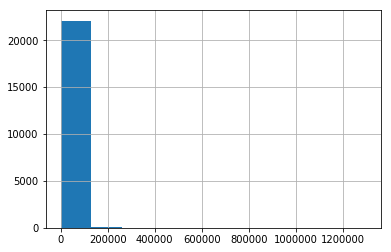

In [18]:
%matplotlib inline
df[df['Element Code']== 5142]['Y2017'].hist()
df[df['Element Code']== 5142]['Y2017'].describe()